In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

train_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/train.csv')
test_df = pd.read_csv('/kaggle/input/mlp-term-2-2025-kaggle-assignment-1/test.csv')



# Data Exploration

In [3]:
# Display shape and first few rows
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()

# View data types
print(" Data Types:\n")
print(train_df.dtypes)

# View basic info
print("\n Info Summary:\n")
train_df.info()

# View descriptive statistics
print("\n Descriptive Statistics (Numerical Columns):\n")
print(train_df.describe())

# View missing values
print("\n Missing Values:\n")
print(train_df.isnull().sum())

Train shape: (40000, 12)
Test shape: (10000, 11)
 Data Types:

id               int64
airline         object
flight          object
source          object
departure       object
stops           object
arrival         object
destination     object
class           object
duration       float64
days_left      float64
price            int64
dtype: object

 Info Summary:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           40000 non-null  int64  
 1   airline      35387 non-null  object 
 2   flight       40000 non-null  object 
 3   source       40000 non-null  object 
 4   departure    35208 non-null  object 
 5   stops        37681 non-null  object 
 6   arrival      40000 non-null  object 
 7   destination  40000 non-null  object 
 8   class        40000 non-null  object 
 9   duration     36987 non-null  float64
 10  days_left   

#  Handle Missing Values and Duplicates

In [4]:
# Impute categorical columns with mode
for col in ['airline', 'departure', 'stops']:
    mode_val = train_df[col].mode()[0]
    train_df[col].fillna(mode_val, inplace=True)

# Impute 'duration' and 'days_left' with median
train_df['duration'].fillna(train_df['duration'].median(), inplace=True)
train_df['days_left'].fillna(train_df['days_left'].median(), inplace=True)

# Clean 'flight' column - replace "0.00E+00" or float-like strings with NaN, then mode
train_df['flight'] = train_df['flight'].astype(str)
train_df['flight'] = train_df['flight'].replace(r'[^A-Za-z0-9\-]', np.nan, regex=True)
train_df['flight'].fillna(train_df['flight'].mode()[0], inplace=True)

# Check for duplicate rows
print("\n Duplicate Rows:\n")
duplicate_rows = train_df[train_df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")
print(duplicate_rows.head()) 


 Duplicate Rows:

Number of duplicate rows: 0
Empty DataFrame
Columns: [id, airline, flight, source, departure, stops, arrival, destination, class, duration, days_left, price]
Index: []


In [5]:
print("\n Missing Values:\n")
print(train_df.isnull().sum())


 Missing Values:

id             0
airline        0
flight         0
source         0
departure      0
stops          0
arrival        0
destination    0
class          0
duration       0
days_left      0
price          0
dtype: int64


# Handle Outliers

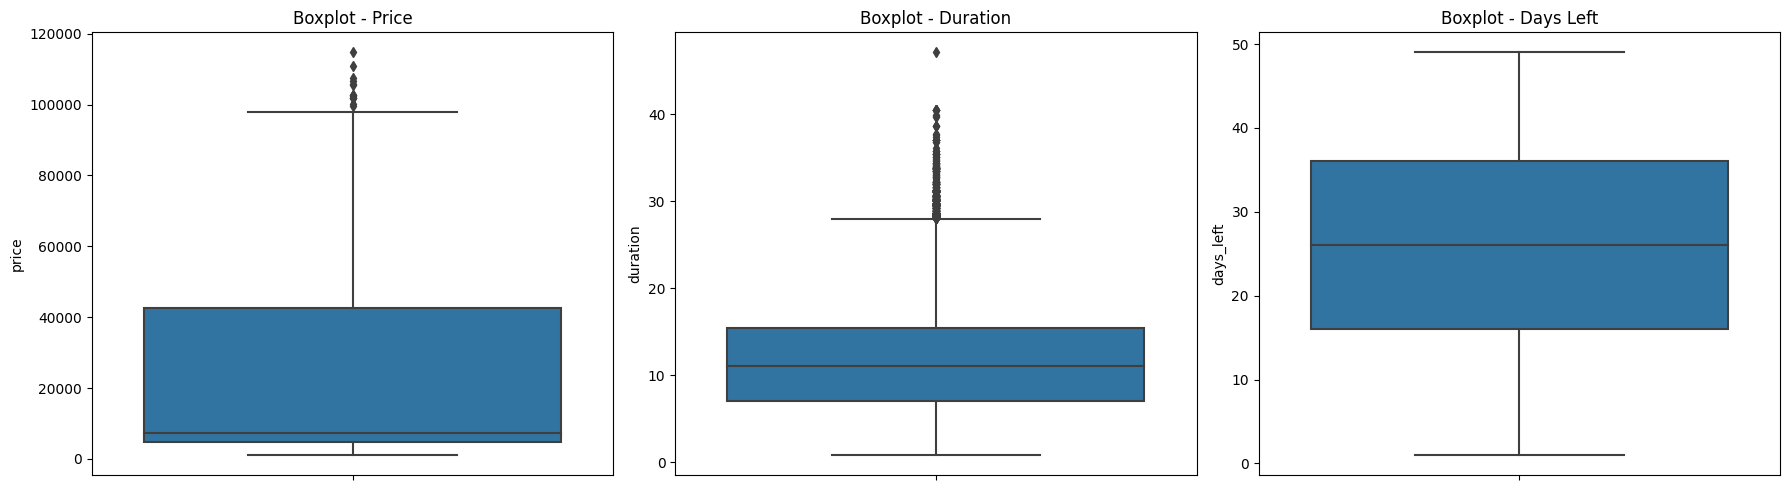

In [6]:
# Visualizing outliers
plt.figure(figsize=(18, 5))

# Price
plt.subplot(1, 3, 1)
sns.boxplot(data=train_df, y='price')
plt.title('Boxplot - Price')

# Duration
plt.subplot(1, 3, 2)
sns.boxplot(data=train_df, y='duration')
plt.title('Boxplot - Duration')

# Days Left
plt.subplot(1, 3, 3)
sns.boxplot(data=train_df, y='days_left')
plt.title('Boxplot - Days Left')

plt.tight_layout()
plt.show()

In [7]:
# 1. Remove Price Outliers above ₹100,000
train_df = train_df[train_df['price'] <= 100000]

# 2. Cap Duration to 95th percentile (~30 hours)
duration_cap = train_df['duration'].quantile(0.95)
train_df['duration'] = np.where(train_df['duration'] > duration_cap, duration_cap, train_df['duration'])

# 3. Days Left — no action needed

# Final check
print("New shape after outlier handling:", train_df.shape)


New shape after outlier handling: (39987, 12)


# Data Visualizations 

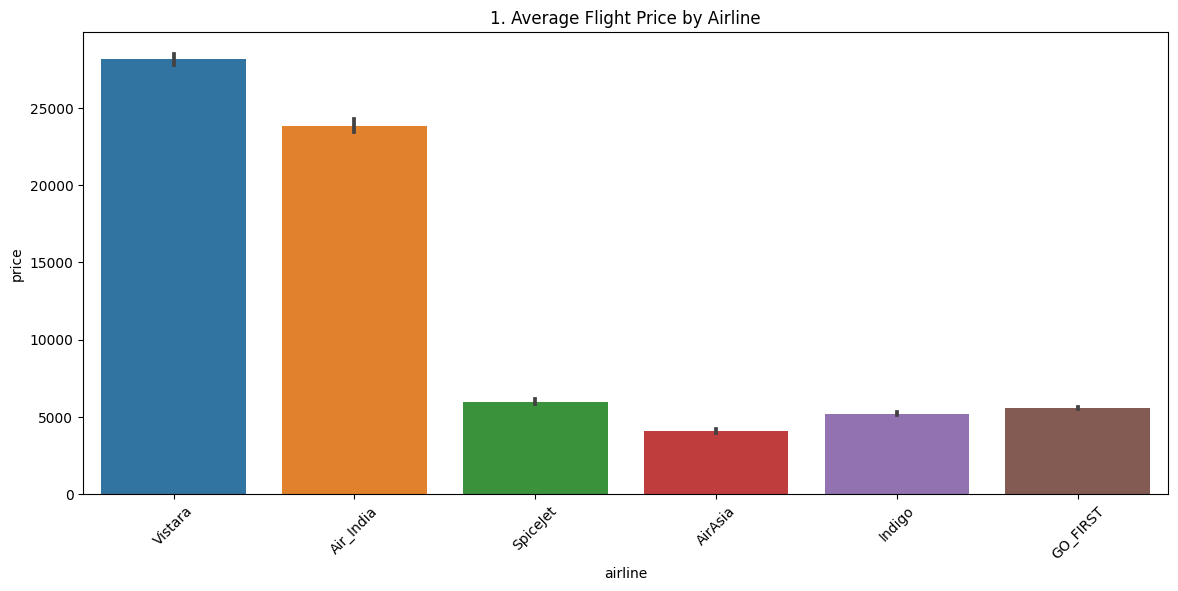

Insight: Some airlines like Vistara and Air India have higher average ticket prices, likely due to business class or longer routes.



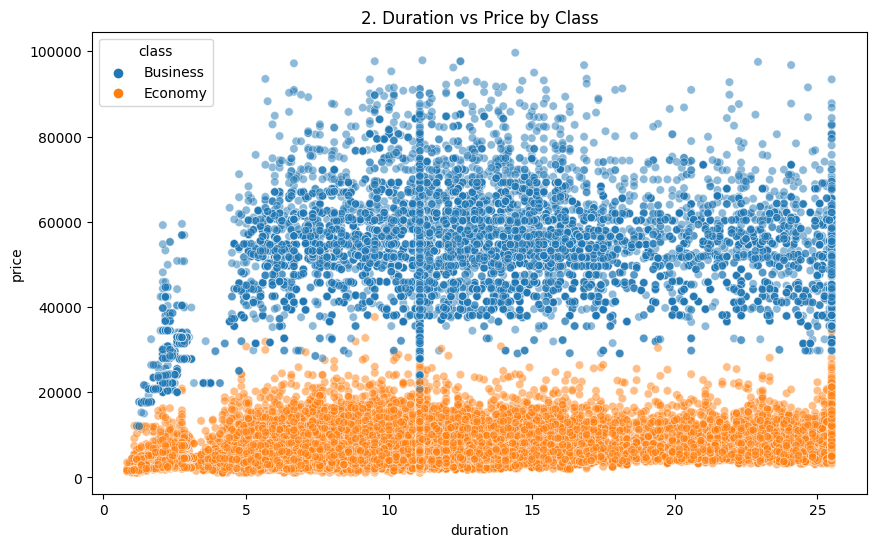

Insight: Longer flights generally cost more, especially in Business class.



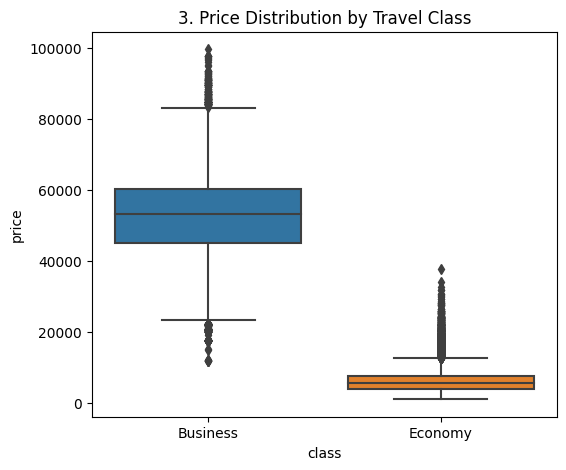

Insight: Business class flights have a much higher and more varied price distribution than Economy class.



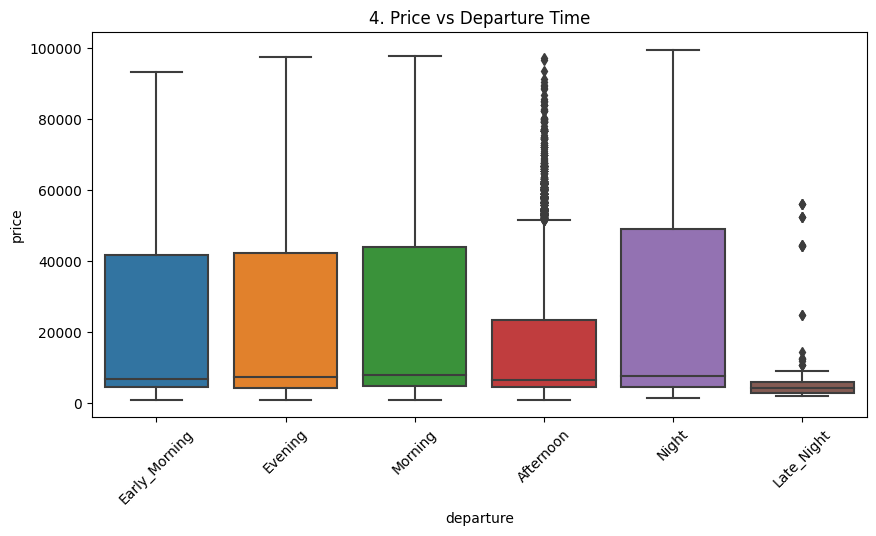

Insight: Flights departing in the Late Night tend to be the cheapest, while Night departures have the highest price variability. Afternoon flights are also relatively low-priced compared to other times.



In [8]:
plt.figure(figsize=(14, 6))
sns.barplot(data=train_df, x='airline', y='price', estimator=np.mean)
plt.xticks(rotation=45)
plt.title("1️. Average Flight Price by Airline")
plt.show()

print("Insight: Some airlines like Vistara and Air India have higher average ticket prices, likely due to business class or longer routes.\n")

# 2. Price vs Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='duration', y='price', hue='class', alpha=0.5)
plt.title("2️. Duration vs Price by Class")
plt.show()

print("Insight: Longer flights generally cost more, especially in Business class.\n")

# 3. Class vs Price
plt.figure(figsize=(6, 5))
sns.boxplot(data=train_df, x='class', y='price')
plt.title("3️. Price Distribution by Travel Class")
plt.show()

print("Insight: Business class flights have a much higher and more varied price distribution than Economy class.\n")

# 4. Departure Time vs Price
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x='departure', y='price')
plt.title("4️. Price vs Departure Time")
plt.xticks(rotation=45)
plt.show()

print("Insight: Flights departing in the Late Night tend to be the cheapest, while Night departures have the highest price variability. Afternoon flights are also relatively low-priced compared to other times.\n")

# Feature Engineering & Encoding

In [9]:
train_df.drop(['id', 'flight'], axis=1, inplace=True)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['class'] = le.fit_transform(train_df['class'])  # Business=0, Economy=1
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding Mapping:", label_mapping)

Label Encoding Mapping: {'Business': 0, 'Economy': 1}


In [11]:
categorical_cols = ['airline', 'source', 'departure', 'stops', 'arrival', 'destination']
train_df = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
print(train_df.columns)  # all new one-hot encoded columns
print(train_df.head())  

Index(['class', 'duration', 'days_left', 'price', 'airline_Air_India',
       'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet',
       'airline_Vistara', 'source_Chennai', 'source_Delhi', 'source_Hyderabad',
       'source_Kolkata', 'source_Mumbai', 'departure_Early_Morning',
       'departure_Evening', 'departure_Late_Night', 'departure_Morning',
       'departure_Night', 'stops_two_or_more', 'stops_zero',
       'arrival_Early_Morning', 'arrival_Evening', 'arrival_Late_Night',
       'arrival_Morning', 'arrival_Night', 'destination_Chennai',
       'destination_Delhi', 'destination_Hyderabad', 'destination_Kolkata',
       'destination_Mumbai'],
      dtype='object')
   class  duration  days_left  price  airline_Air_India  airline_GO_FIRST  \
0      0     11.08       40.0  64173              False             False   
1      1     16.08       26.0   4357               True             False   
2      1      2.92       25.0   3251              False             False   
3     

In [12]:
from sklearn.preprocessing import StandardScaler
# Save original for comparison
unscaled = train_df[['duration', 'days_left']].copy()
# Apply scaling
scaler = StandardScaler()
train_df[['duration', 'days_left']] = scaler.fit_transform(train_df[['duration', 'days_left']])
# Compare
print("Before scaling:\n", unscaled.head())
print("After scaling:\n", train_df[['duration', 'days_left']].head())

Before scaling:
    duration  days_left
0     11.08       40.0
1     16.08       26.0
2      2.92       25.0
3      1.50       22.0
4      4.83       20.0
After scaling:
    duration  days_left
0 -0.113932   1.088309
1  0.643806  -0.014271
2 -1.350560  -0.093027
3 -1.565757  -0.329294
4 -1.061104  -0.486806


In [13]:
print("Final columns for modeling:", train_df.columns.tolist())
print("Dataset shape:", train_df.shape)

Final columns for modeling: ['class', 'duration', 'days_left', 'price', 'airline_Air_India', 'airline_GO_FIRST', 'airline_Indigo', 'airline_SpiceJet', 'airline_Vistara', 'source_Chennai', 'source_Delhi', 'source_Hyderabad', 'source_Kolkata', 'source_Mumbai', 'departure_Early_Morning', 'departure_Evening', 'departure_Late_Night', 'departure_Morning', 'departure_Night', 'stops_two_or_more', 'stops_zero', 'arrival_Early_Morning', 'arrival_Evening', 'arrival_Late_Night', 'arrival_Morning', 'arrival_Night', 'destination_Chennai', 'destination_Delhi', 'destination_Hyderabad', 'destination_Kolkata', 'destination_Mumbai']
Dataset shape: (39987, 31)


# Model Training

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np
import random

np.random.seed(42)
random.seed(42)
# Separate features and target
X = train_df.drop('price', axis=1)
y = train_df['price']

# 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model_scores = []

### Model 1: Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_val)
r2_lr = r2_score(y_val, y_pred_lr)
rmse_lr = mean_squared_error(y_val, y_pred_lr, squared=False)
mae_lr = mean_absolute_error(y_val, y_pred_lr)

print(f"Linear Regression - R2: {r2_lr:.4f}, RMSE: {rmse_lr:.2f}, MAE: {mae_lr:.2f}")
model_scores.append({'Model': 'Linear Regression', 'R2 Score': r2_lr, 'RMSE': rmse_lr, 'MAE': mae_lr, 'Tuned?': 'No'})

Linear Regression - R2: 0.9110, RMSE: 6740.52, MAE: 4566.31


### Model 2: Ridge Regression

In [16]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_val)
r2_ridge = r2_score(y_val, y_pred_ridge)
rmse_ridge = mean_squared_error(y_val, y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_val, y_pred_ridge)

print(f"Ridge Regression - R2: {r2_ridge:.4f}, RMSE: {rmse_ridge:.2f}, MAE: {mae_ridge:.2f}")
model_scores.append({'Model': 'Ridge Regression', 'R2 Score': r2_ridge, 'RMSE': rmse_ridge, 'MAE': mae_ridge, 'Tuned?': 'No'})

Ridge Regression - R2: 0.9110, RMSE: 6740.50, MAE: 4566.28


### Model 3: Lasso Regression

In [17]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_val)
r2_lasso = r2_score(y_val, y_pred_lasso)
rmse_lasso = mean_squared_error(y_val, y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_val, y_pred_lasso)

print(f"Lasso Regression - R2: {r2_lasso:.4f}, RMSE: {rmse_lasso:.2f}, MAE: {mae_lasso:.2f}")
model_scores.append({'Model': 'Lasso Regression', 'R2 Score': r2_lasso, 'RMSE': rmse_lasso, 'MAE': mae_lasso, 'Tuned?': 'No'})

Lasso Regression - R2: 0.9110, RMSE: 6741.23, MAE: 4565.51


### Model 4: Decision Tree Regressor

In [18]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_val)
r2_dt = r2_score(y_val, y_pred_dt)
rmse_dt = mean_squared_error(y_val, y_pred_dt, squared=False)
mae_dt = mean_absolute_error(y_val, y_pred_dt)

print(f"Decision Tree - R2: {r2_dt:.4f}, RMSE: {rmse_dt:.2f}, MAE: {mae_dt:.2f}")
model_scores.append({'Model': 'Decision Tree', 'R2 Score': r2_dt, 'RMSE': rmse_dt, 'MAE': mae_dt, 'Tuned?': 'No'})

Decision Tree - R2: 0.9460, RMSE: 5251.86, MAE: 2482.36


### Model 5: Random Forest Regressor

In [19]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
r2_rf = r2_score(y_val, y_pred_rf)
rmse_rf = mean_squared_error(y_val, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_val, y_pred_rf)

print(f"Random Forest - R2: {r2_rf:.4f}, RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}")
model_scores.append({'Model': 'Random Forest', 'R2 Score': r2_rf, 'RMSE': rmse_rf, 'MAE': mae_rf, 'Tuned?': 'No'})

Random Forest - R2: 0.9692, RMSE: 3963.98, MAE: 2151.14


### Model 6: Gradient Boosting Regressor

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_val)
r2_gb = r2_score(y_val, y_pred_gb)
rmse_gb = mean_squared_error(y_val, y_pred_gb, squared=False)
mae_gb = mean_absolute_error(y_val, y_pred_gb)

print(f"Gradient Boosting - R2: {r2_gb:.4f}, RMSE: {rmse_gb:.2f}, MAE: {mae_gb:.2f}")
model_scores.append({'Model': 'Gradient Boosting', 'R2 Score': r2_gb, 'RMSE': rmse_gb, 'MAE': mae_gb, 'Tuned?': 'No'})

Gradient Boosting - R2: 0.9483, RMSE: 5135.25, MAE: 3090.09


### Model 7: AdaBoost Regressor

In [21]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(random_state=42)
ada.fit(X_train, y_train)

y_pred_ada = ada.predict(X_val)
r2_ada = r2_score(y_val, y_pred_ada)
rmse_ada = mean_squared_error(y_val, y_pred_ada, squared=False)
mae_ada = mean_absolute_error(y_val, y_pred_ada)

print(f"AdaBoost - R2: {r2_ada:.4f}, RMSE: {rmse_ada:.2f}, MAE: {mae_ada:.2f}")
model_scores.append({'Model': 'AdaBoost', 'R2 Score': r2_ada, 'RMSE': rmse_ada, 'MAE': mae_ada, 'Tuned?': 'No'})

AdaBoost - R2: 0.9283, RMSE: 6051.35, MAE: 3757.00


### Model 8: XGBoost Regressor

In [22]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=6)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)
r2_xgb = r2_score(y_val, y_pred_xgb)
rmse_xgb = mean_squared_error(y_val, y_pred_xgb, squared=False)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

print(f"XGBoost - R2: {r2_xgb:.4f}, RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}")
model_scores.append({'Model': 'XGBoost', 'R2 Score': r2_xgb, 'RMSE': rmse_xgb, 'MAE': mae_xgb, 'Tuned?': 'No'})

XGBoost - R2: 0.9670, RMSE: 4105.42, MAE: 2417.76


### Model 9: LightGBM Regressor

In [23]:
from lightgbm import LGBMRegressor

lgb = LGBMRegressor(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=6)
lgb.fit(X_train, y_train)

y_pred_lgb = lgb.predict(X_val)
r2_lgb = r2_score(y_val, y_pred_lgb)
rmse_lgb = mean_squared_error(y_val, y_pred_lgb, squared=False)
mae_lgb = mean_absolute_error(y_val, y_pred_lgb)

print(f"LightGBM - R2: {r2_lgb:.4f}, RMSE: {rmse_lgb:.2f}, MAE: {mae_lgb:.2f}")
model_scores.append({'Model': 'LightGBM', 'R2 Score': r2_lgb, 'RMSE': rmse_lgb, 'MAE': mae_lgb, 'Tuned?': 'No'})

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 355
[LightGBM] [Info] Number of data points in the train set: 31989, number of used features: 30
[LightGBM] [Info] Start training from score 20773.397105
LightGBM - R2: 0.9648, RMSE: 4236.23, MAE: 2507.17


# Hyperparameter Tuning

### 1. Random Forest Regressor – Tuning

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}

rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

print("Best Params for Random Forest:", rf_grid.best_params_)

# Evaluate tuned model
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_val)
print(f"R²: {r2_score(y_val, rf_pred):.4f}, RMSE: {mean_squared_error(y_val, rf_pred, squared=False):.2f}")
model_scores.append({'Model': 'Random Forest (Tuned)', 'R2 Score': r2_score(y_val, rf_pred), 'RMSE': mean_squared_error(y_val, rf_pred, squared=False), 'MAE': mean_absolute_error(y_val, rf_pred), 'Tuned?': 'Yes'})

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
R²: 0.9699, RMSE: 3920.13


### 2. Gradient Boosting Regressor – Tuning

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
}

gb_grid = GridSearchCV(gb_model, gb_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
gb_grid.fit(X_train, y_train)

print("Best Params for Gradient Boosting:", gb_grid.best_params_)

# Evaluate tuned model
gb_best = gb_grid.best_estimator_
gb_pred = gb_best.predict(X_val)
print(f"R²: {r2_score(y_val, gb_pred):.4f}, RMSE: {mean_squared_error(y_val, gb_pred, squared=False):.2f}")
model_scores.append({'Model': 'Gradient Boosting (Tuned)', 'R2 Score': r2_score(y_val, gb_pred), 'RMSE': mean_squared_error(y_val, gb_pred, squared=False), 'MAE': mean_absolute_error(y_val, gb_pred), 'Tuned?': 'Yes'})

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
R²: 0.9634, RMSE: 4325.64


### 3. Decision Tree Regressor – Tuning

In [26]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)

dt_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid = GridSearchCV(dt_model, dt_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
dt_grid.fit(X_train, y_train)

print("Best Params for Decision Tree:", dt_grid.best_params_)

# Evaluate tuned model
dt_best = dt_grid.best_estimator_
dt_pred = dt_best.predict(X_val)
print(f"R²: {r2_score(y_val, dt_pred):.4f}, RMSE: {mean_squared_error(y_val, dt_pred, squared=False):.2f}")
model_scores.append({'Model': 'Decision Tree (Tuned)', 'R2 Score': r2_score(y_val, dt_pred), 'RMSE': mean_squared_error(y_val, dt_pred, squared=False), 'MAE': mean_absolute_error(y_val, dt_pred), 'Tuned?': 'Yes'})

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Params for Decision Tree: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10}
R²: 0.9606, RMSE: 4485.85


### 4. XGBoost Regressor – Tuning

In [27]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_model = XGBRegressor(random_state=42)

xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7]
}

xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

print("Best Params for XGBoost:", xgb_grid.best_params_)

xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_val)

print(f"XGBoost (Tuned) - R2: {r2_score(y_val, xgb_pred):.4f}, RMSE: {mean_squared_error(y_val, xgb_pred, squared=False):.2f}")
model_scores.append({
    'Model': 'XGBoost (Tuned)',
    'R2 Score': r2_score(y_val, xgb_pred),
    'RMSE': mean_squared_error(y_val, xgb_pred, squared=False),
    'MAE': mean_absolute_error(y_val, xgb_pred),
    'Tuned?': 'Yes'
})

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Params for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
XGBoost (Tuned) - R2: 0.9692, RMSE: 3965.27


### 5. LightGBM Regressor – Tuning

In [28]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(random_state=42)

lgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10, 15]
}

lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
lgb_grid.fit(X_train, y_train)

print("Best Params for LightGBM:", lgb_grid.best_params_)

lgb_best = lgb_grid.best_estimator_
lgb_pred = lgb_best.predict(X_val)

print(f"LightGBM (Tuned) - R2: {r2_score(y_val, lgb_pred):.4f}, RMSE: {mean_squared_error(y_val, lgb_pred, squared=False):.2f}")
model_scores.append({
    'Model': 'LightGBM (Tuned)',
    'R2 Score': r2_score(y_val, lgb_pred),
    'RMSE': mean_squared_error(y_val, lgb_pred, squared=False),
    'MAE': mean_absolute_error(y_val, lgb_pred),
    'Tuned?': 'Yes'
})


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 21326, number of used features: 30
[LightGBM] [Info] Start training from score 20627.411470
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

In [29]:
print(model_scores)

[{'Model': 'Linear Regression', 'R2 Score': 0.9110063460115528, 'RMSE': 6740.524140452821, 'MAE': 4566.310422663313, 'Tuned?': 'No'}, {'Model': 'Ridge Regression', 'R2 Score': 0.911007019907629, 'RMSE': 6740.498619411906, 'MAE': 4566.282012326096, 'Tuned?': 'No'}, {'Model': 'Lasso Regression', 'R2 Score': 0.9109877290705739, 'RMSE': 6741.229142283402, 'MAE': 4565.511641031705, 'Tuned?': 'No'}, {'Model': 'Decision Tree', 'R2 Score': 0.9459745411881492, 'RMSE': 5251.862907424044, 'MAE': 2482.3595148787194, 'Tuned?': 'No'}, {'Model': 'Random Forest', 'R2 Score': 0.9692224667926069, 'RMSE': 3963.976336888254, 'MAE': 2151.135178834391, 'Tuned?': 'No'}, {'Model': 'Gradient Boosting', 'R2 Score': 0.9483470382784864, 'RMSE': 5135.252033791976, 'MAE': 3090.0949052460596, 'Tuned?': 'No'}, {'Model': 'AdaBoost', 'R2 Score': 0.9282739854741074, 'RMSE': 6051.353154388451, 'MAE': 3757.0008466035356, 'Tuned?': 'No'}, {'Model': 'XGBoost', 'R2 Score': 0.966986778379565, 'RMSE': 4105.424811453999, 'MAE':

# Model Performance Comparison 

In [30]:
results_df = pd.DataFrame(model_scores)
results_df['R2 Score'] = results_df['R2 Score'].round(4)
results_df['RMSE'] = results_df['RMSE'].astype(int)
results_df['MAE'] = results_df['MAE'].astype(int) 

results_df = results_df.sort_values(by='R2 Score', ascending=False).reset_index(drop=True)
display(results_df)

,Model,R2 Score,RMSE,MAE,Tuned?
0,Random Forest (Tuned),0.9699,3920,2154,Yes
1,Random Forest,0.9692,3963,2151,No
2,XGBoost (Tuned),0.9692,3965,2293,Yes
3,XGBoost,0.9670,4105,2417,No
4,LightGBM (Tuned),0.9667,4125,2442,Yes
5,LightGBM,0.9648,4236,2507,No
6,Gradient Boosting (Tuned),0.9634,4325,2569,Yes
7,Decision Tree (Tuned),0.9606,4485,2504,Yes
8,Gradient Boosting,0.9483,5135,3090,No
9,Decision Tree,0.9460,5251,2482,No


### 1. Bar Plot: R2 Score vs Model

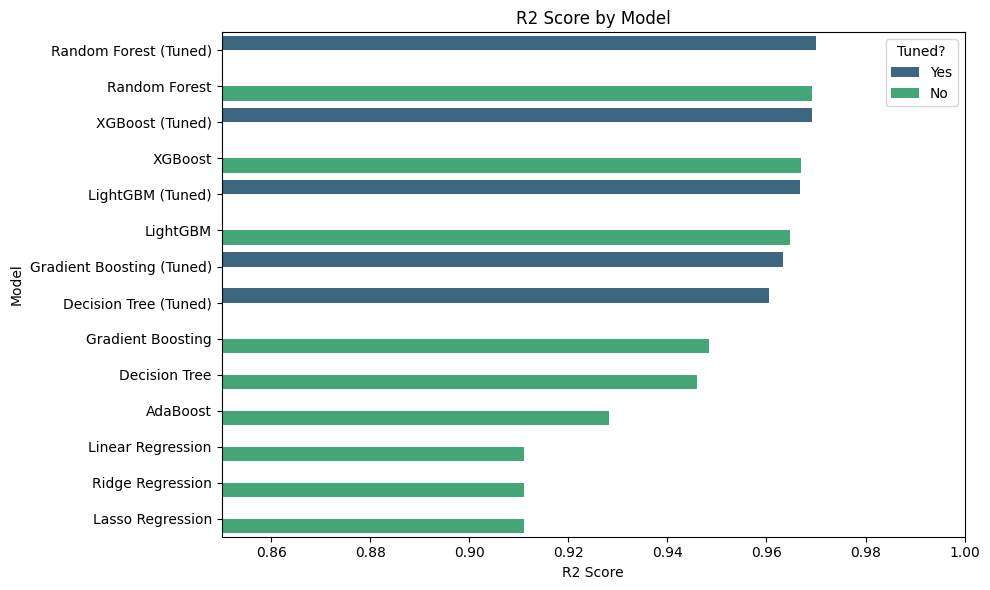

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='R2 Score', y='Model', hue='Tuned?', palette='viridis')
plt.title('R2 Score by Model') # Higher R2, Better the model
plt.xlabel('R2 Score')
plt.ylabel('Model')
plt.xlim(0.85, 1)
plt.tight_layout()
plt.show()

### 2. Bar Plot: RMSE vs Model

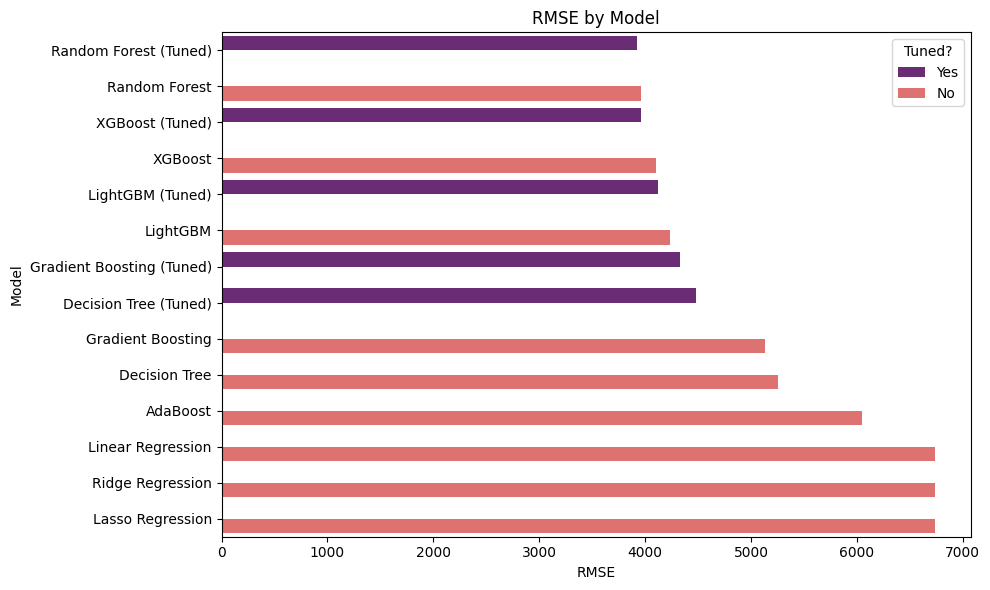

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='RMSE', y='Model', hue='Tuned?', palette='magma')
plt.title('RMSE by Model') # Lower the Error, Better the model
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

### 3. Bar Plot: MAE vs Model

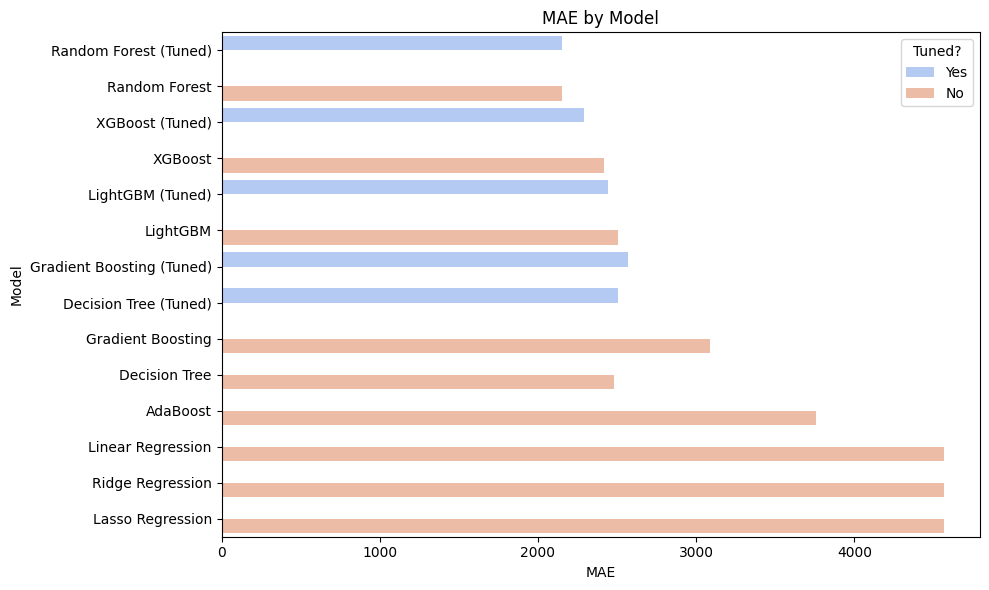

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='MAE', y='Model', hue='Tuned?', palette='coolwarm')
plt.title('MAE by Model') # Lower the Error, Better the model
plt.xlabel('MAE')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

### 4. Actual vs Predicted Scatter Plot (Random Forest Tuned)

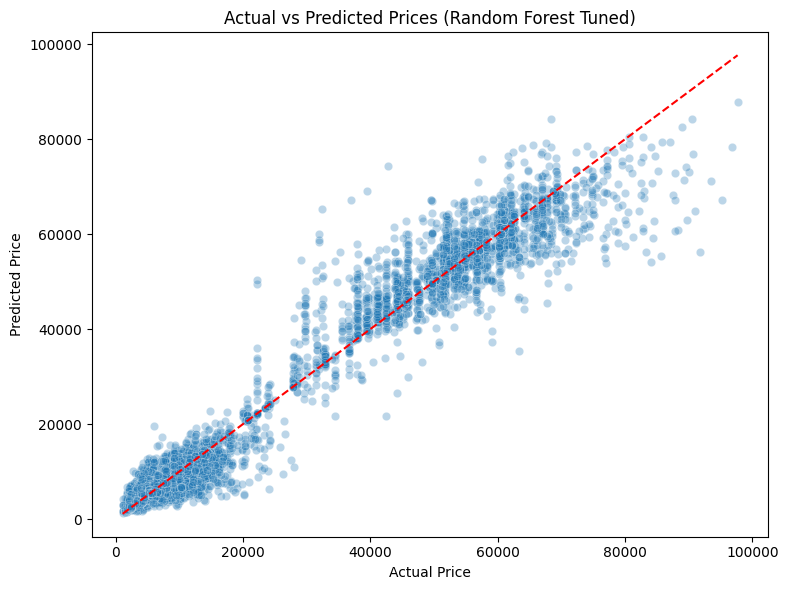

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

y_val_pred = rf_best.predict(X_val)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Random Forest Tuned)")
plt.tight_layout()
plt.show()

# Model Performance Summary

I trained 14 models in total — 9 base models and 5 tuned versions — and compared them using R2 Score, RMSE, and MAE on the validation set.

The Tuned Random Forest performed the best with an R2 of 0.9699, RMSE of 3920, and MAE of 2154.

I additionally introduced XGBoost and LightGBM models, both untuned and tuned. Their tuned versions performed quite well, coming close to the performance of the tuned Random Forest.

The Actual vs Predicted scatter plot shows a strong alignment close to the ideal diagonal for the best models, indicating excellent predictive accuracy.

Bar plots highlight that tree-based ensemble models, especially after hyperparameter tuning, significantly outperform linear models.

Based on these results, we selected the Tuned Random Forest as the final model for test prediction and Kaggle submission

# Predict on Test Set 

In [35]:
test_id = test_df['id']
print("Test shape:", test_df.shape)

Test shape: (10000, 11)


In [36]:
# Fill missing values (same logic as train)
test_df['airline'].fillna('Unknown', inplace=True)
test_df['departure'].fillna('Unknown', inplace=True)
test_df['stops'].fillna('one', inplace=True)
test_df['duration'].fillna(train_df['duration'].median(), inplace=True)
test_df['days_left'].fillna(train_df['days_left'].median(), inplace=True)

# Label encode 'class'
test_df['class'] = le.transform(test_df['class'])

# One-hot encode categorical columns
categorical_cols = ['airline', 'source', 'departure', 'stops', 'arrival', 'destination']
test_df = pd.get_dummies(test_df, columns=categorical_cols)

# Align with training data columns
X_test = test_df.drop(columns=['id'])
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Scale numeric columns
X_test[['duration', 'days_left']] = scaler.transform(X_test[['duration', 'days_left']])

# Submission CSV

In [37]:
y_test_pred = rf_best.predict(X_test)

In [38]:
submission_df = pd.DataFrame({
    'id': test_id,
    'price': y_test_pred.astype(int)  # Round to integer prices
})

submission_df.to_csv("submission.csv", index=False)
print("submission.csv saved!")

submission.csv saved!
